In [77]:
import pandas as pd

In [78]:
df = pd.read_csv('execution_times - execution_times (1).csv')

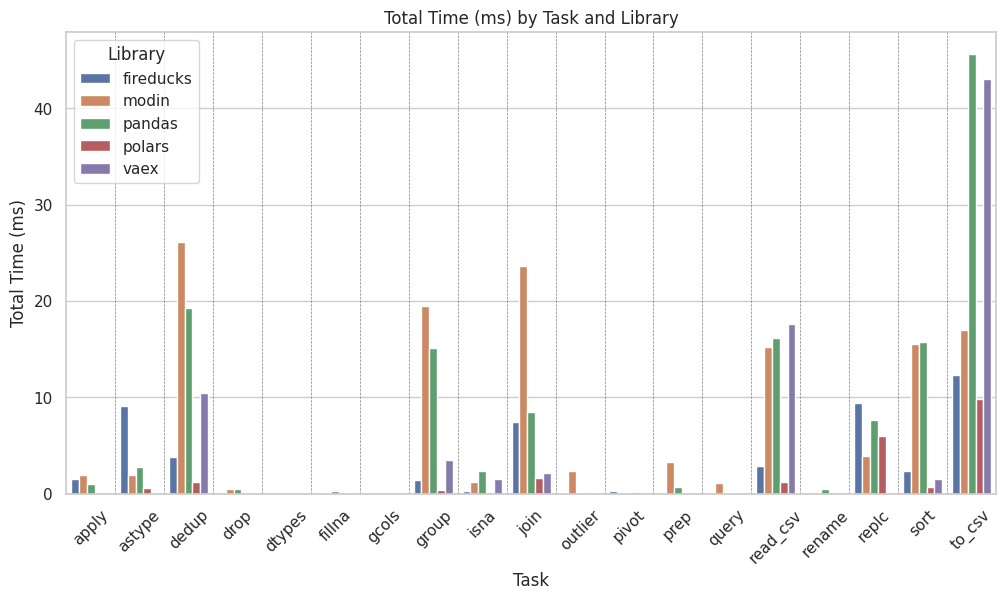

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データの集計
grouped_df = df.groupby(['lib', 'task'])['ttl_ms'].sum().reset_index()

# 可視化
plt.figure(figsize=(12, 6))
sns.barplot(x='task', y='ttl_ms', hue='lib', data=grouped_df)
plt.title('Total Time (ms) by Task and Library')
plt.xlabel('Task')
plt.ylabel('Total Time (ms)')

# X軸の各タスク間に点線を追加
for i in range(len(grouped_df['task'].unique()) - 1):
    plt.axvline(i + 0.5, color='grey', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)
plt.legend(title='Library')
plt.show()


In [80]:
df = df[['lib','task','ttl_ms']].groupby(['lib','task']).max().reset_index()

In [81]:
df.lib.unique()

array(['fireducks', 'modin', 'pandas', 'polars', 'vaex'], dtype=object)

In [83]:
# Pandasの基準値を取得
pandas_benchmark = df[df['lib'] == 'pandas'].set_index('task')['ttl_ms']

# Pandasの基準TTLを各行に追加
df['pandas_ttl'] = df['task'].map(pandas_benchmark)

# 各ライブラリのリフト値を計算
def calculate_lift(row):
    if row['lib'] != 'pandas' and row['pandas_ttl'] is not None:
        return row['pandas_ttl'] / row['ttl_ms']
    return None

df['lift'] = df.apply(calculate_lift, axis=1)

# 結果を表示
print(df)

          lib      task     ttl_ms  pandas_ttl         lift
0   fireducks     apply   1.580930    1.042966     0.659717
1   fireducks    astype   9.122534    2.743595     0.300749
2   fireducks     dedup   3.826933   19.320993     5.048689
3   fireducks      drop   0.000455    0.491184  1079.190152
4   fireducks    dtypes   0.009159    0.000125     0.013693
..        ...       ...        ...         ...          ...
90       vaex  read_csv  17.593579   16.215357     0.921663
91       vaex    rename   0.000572    0.518459   906.829024
92       vaex     replc   0.123600    7.668056    62.039169
93       vaex      sort   1.546532   15.709973    10.158197
94       vaex    to_csv  43.040662   45.634855     1.060273

[95 rows x 5 columns]


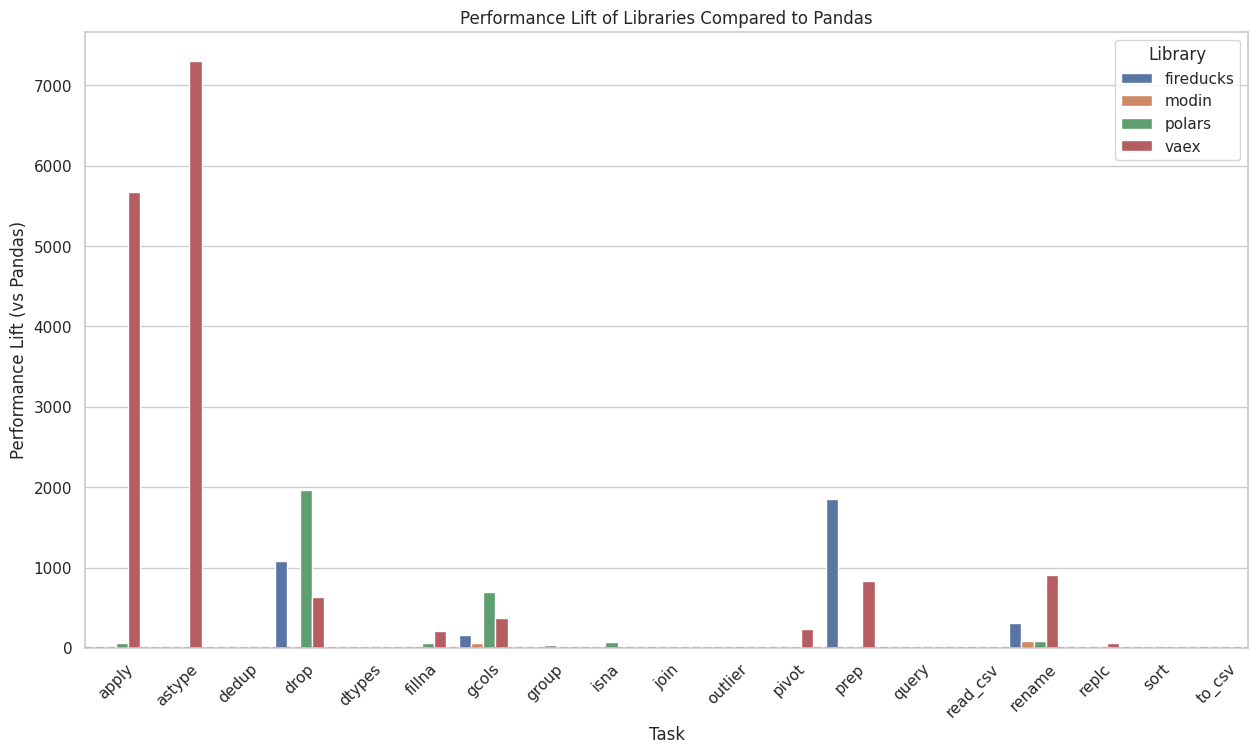

In [85]:
# Pandas以外のライブラリのみをフィルタリング
df_filtered = df[df['lib'] != 'pandas']

# 可視化
plt.figure(figsize=(15, 8))
sns.barplot(x='task', y='lift', hue='lib', data=df_filtered)
plt.axhline(1, color='red', linestyle='--')  # Pandasの基準値を示す線
plt.xlabel('Task')
plt.ylabel('Performance Lift (vs Pandas)')
plt.title('Performance Lift of Libraries Compared to Pandas')
plt.xticks(rotation=45)
plt.legend(title='Library')
plt.show()

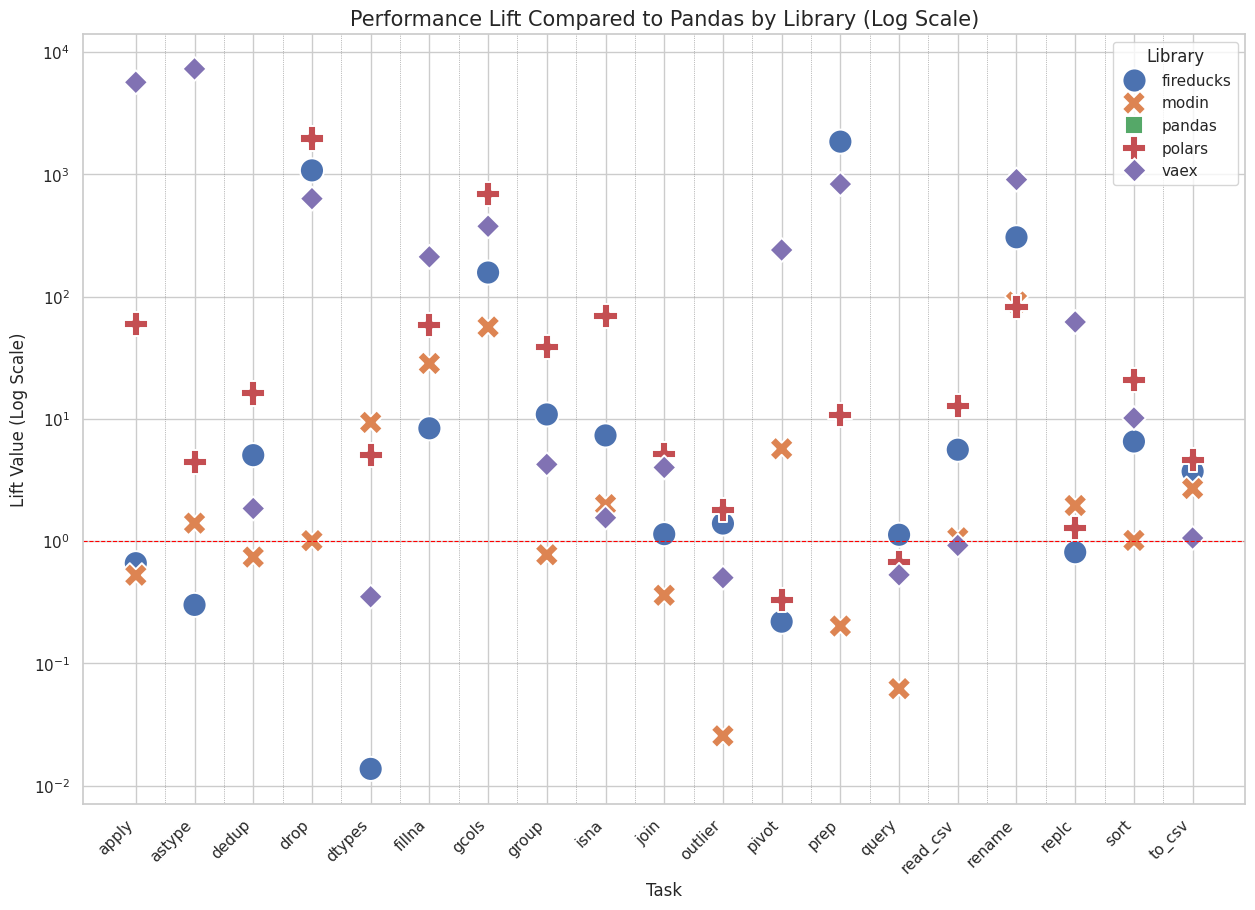

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# グラフの設定
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# 各ライブラリとタスクごとのリフト値をプロット
sns.scatterplot(data=df, x='task', y='lift', hue='lib', style='lib', s=300)

# Pandasの基準値（1）を示す水平線を追加
plt.axhline(1, color='red', linewidth=0.8, linestyle='--')

# タスク間に灰色の波線を追加
for i in range(len(df['task'].unique()) - 1):
    plt.axvline(i + 0.5, color='grey', linewidth=0.5, linestyle=':')

# Y軸を対数尺度に設定
plt.yscale('log')

# グラフの設定
plt.xlabel('Task', fontsize=12)
plt.ylabel('Lift Value (Log Scale)', fontsize=12)
plt.title('Performance Lift Compared to Pandas by Library (Log Scale)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Library')

# グラフの表示
plt.show()


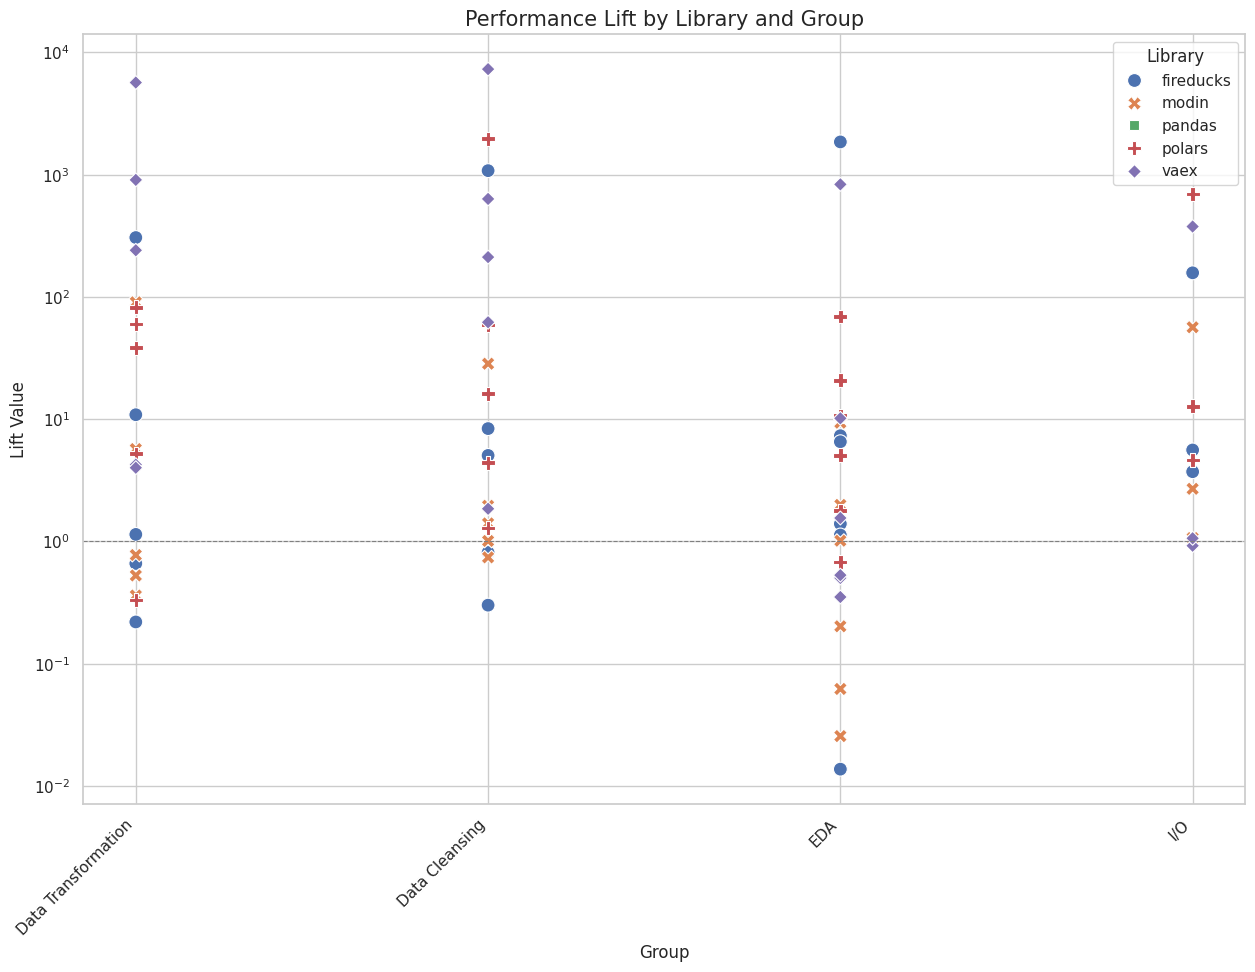

In [90]:
task_groups = {
    'I/O': ['read_csv', 'to_csv', 'gcols'],
    'EDA': ['isna', 'sort', 'prep', 'query', 'dtypes', 'outlier'],
    'Data Transformation': ['join', 'rename', 'group', 'pivot', 'apply', 'rename'],
    'Data Cleansing': ['dedup', 'fillna', 'replc', 'drop', 'astype']
}

# 新しい列 'Group' を追加して、各タスクを適切なグループに分類
df['Group'] = df['task'].apply(lambda x: next((group for group, tasks in task_groups.items() if x in tasks), 'Other'))

# グラフの設定
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# グループ化したX軸を使用してプロット
sns.scatterplot(data=df, x='Group', y='lift', hue='lib', style='lib', s=100)

# Pandasの基準値（1）を示す水平線を追加
plt.axhline(1, color='grey', linewidth=0.8, linestyle='--')

# グラフの設定
plt.xlabel('Group', fontsize=12)
plt.ylabel('Lift Value', fontsize=12)
plt.title('Performance Lift by Library and Group', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Library')
plt.yscale('log')  # Y軸を対数尺度に設定

# グラフの表示
plt.show()

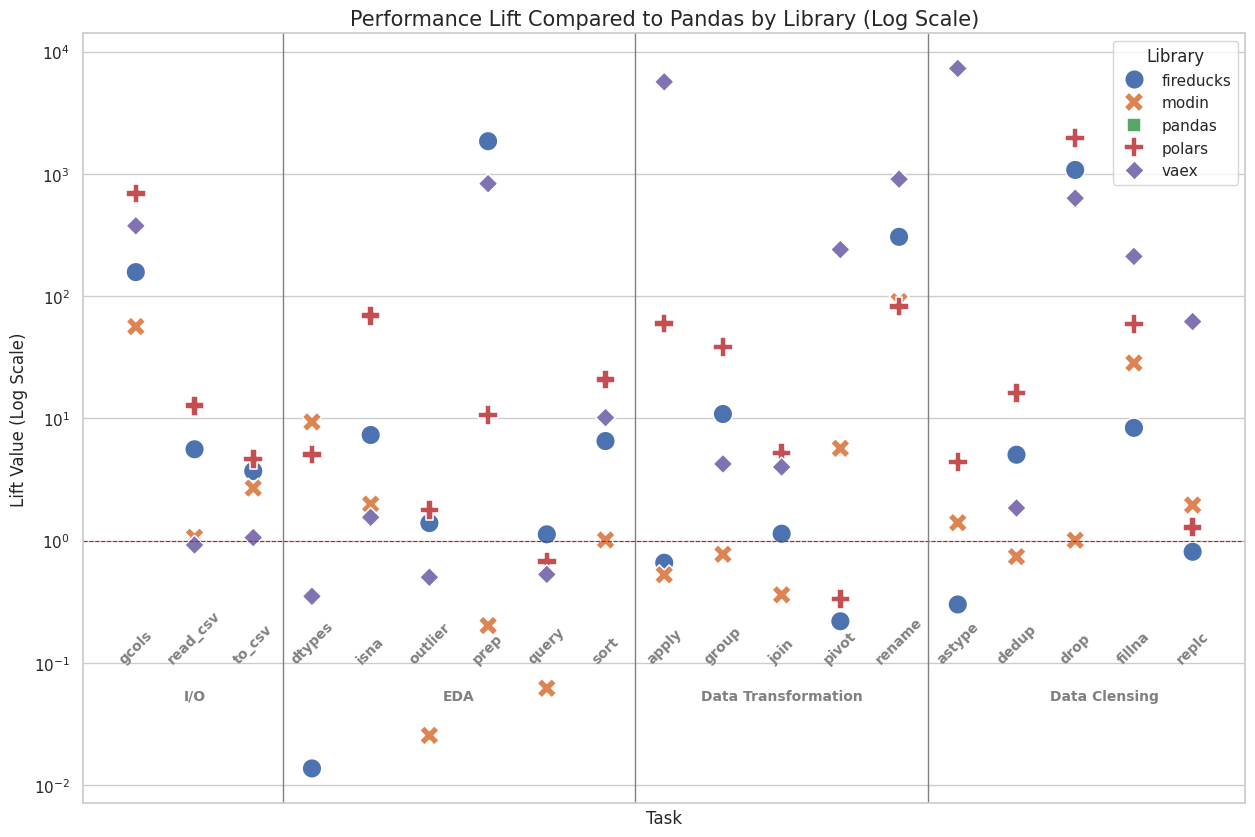

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# タスクをグループに分類
task_groups = {
    'I/O': ['read_csv', 'to_csv', 'gcols'],
    'EDA': ['isna', 'sort', 'prep', 'query', 'dtypes', 'outlier'],
    'Data Transformation': ['join', 'rename', 'group', 'pivot', 'apply', 'rename'],
    'Data Cleansing': ['dedup', 'fillna', 'replc', 'drop', 'astype']
}

# 新しい列 'Group' を追加して、各タスクを適切なグループに分類
df['Group'] = df['task'].apply(lambda x: next((group for group, tasks in task_groups.items() if x in tasks), 'Other'))

# タスクをグループ順に並べ替え
df['GroupOrder'] = df['Group'].map({group: i for i, group in enumerate(task_groups)})
df.sort_values(by=['GroupOrder', 'task'], inplace=True)

# グループの最初のタスクを特定
first_task_in_group = df.drop_duplicates(subset=['Group'])[['Group', 'task']]

# グラフの設定
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# 各ライブラリとタスクごとのリフト値をプロット
sns.scatterplot(data=df, x='task', y='lift', hue='lib', style='lib', s=200)

# Pandasの基準値（1）を示す水平線を追加
plt.axhline(1, color='red', linewidth=0.8, linestyle='--')

# Y軸を対数尺度に設定
plt.yscale('log')

# グループ間に黒い実線を追加

plt.axvline(2 + 0.5, color='gray', linewidth=1)
plt.axvline(8 + 0.5, color='gray', linewidth=1)
plt.axvline(13 + 0.5, color='gray', linewidth=1)

# タスク名を45度傾けて表示
for i, task in enumerate(df['task'].unique()):
    plt.text(i, 0.1, task, rotation=45, horizontalalignment='center', size='small', color='grey', weight='semibold')

# 各グループの最初のタスクの真下に左詰めでグループ名を表示
plt.text(1 , 0.05, 'I/O', horizontalalignment='center', size='small', color='grey',weight='semibold')
plt.text(5.5 , 0.05, 'EDA', horizontalalignment='center', size='small', color='grey',weight='semibold')
plt.text(11 , 0.05, 'Data Transformation', horizontalalignment='center', size='small', color='grey',weight='semibold')
plt.text(16.5 , 0.05, 'Data Clensing', horizontalalignment='center', size='small', color='grey',weight='semibold')

# グラフの設定
plt.xlabel('Task', fontsize=12)
plt.ylabel('Lift Value (Log Scale)', fontsize=12)
plt.title('Performance Lift Compared to Pandas by Library (Log Scale)', fontsize=15)
plt.xticks([])  # X軸のラベルを非表示にする
plt.legend(title='Library')

# グラフの表示
plt.show()


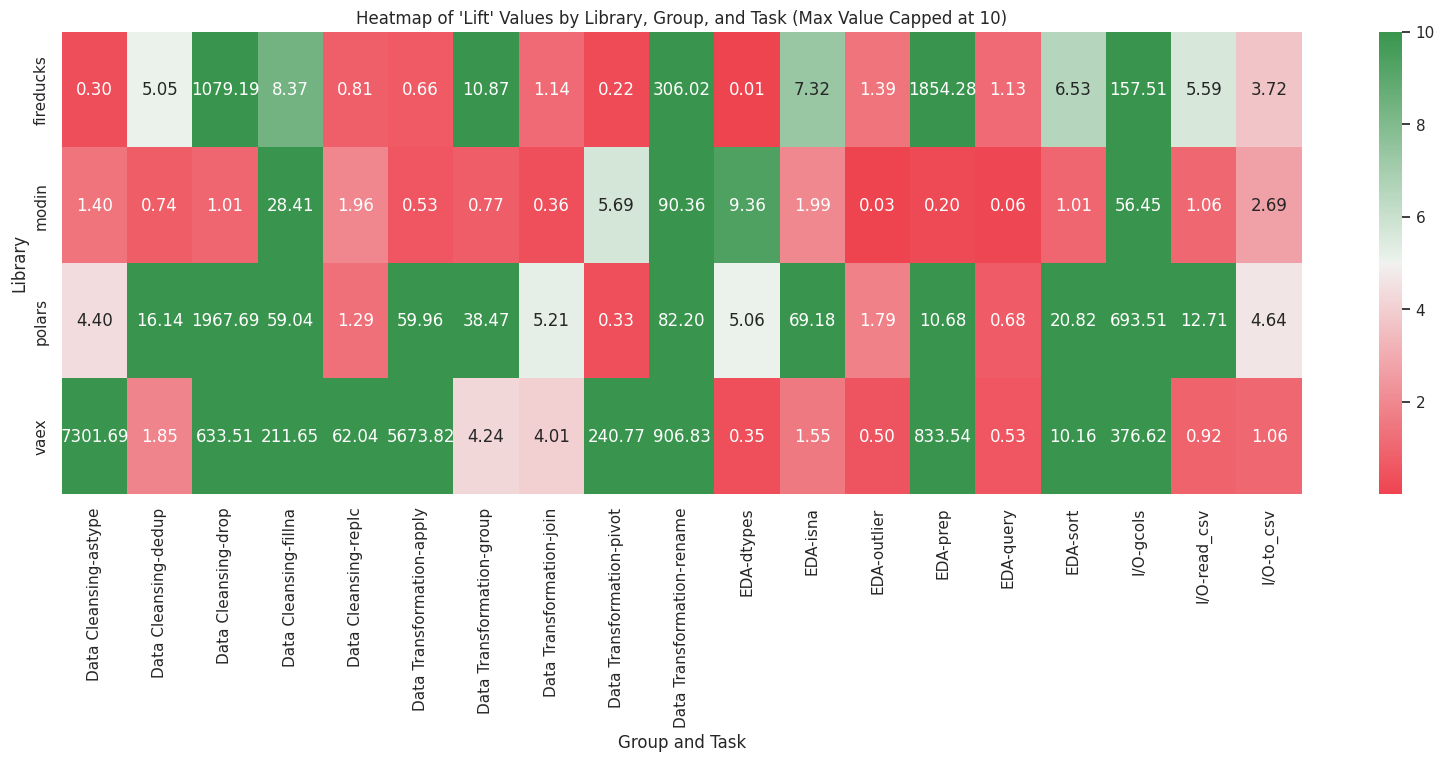

In [92]:
# Pivot the DataFrame
pivot_df = df.pivot_table(index="lib", columns=["Group", "task"], values="lift", aggfunc='mean')

# Create a custom diverging palette (high values in green, low in red)
cmap = sns.diverging_palette(10, 133, s=80, l=55, n=9, as_cmap=True)

# Create and display the heatmap with specified size and color palette
plt.figure(figsize=(20, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap=cmap, vmax=10)
plt.title("Heatmap of 'Lift' Values by Library, Group, and Task (Max Value Capped at 10)")
plt.xlabel("Group and Task")
plt.ylabel("Library")
plt.show()

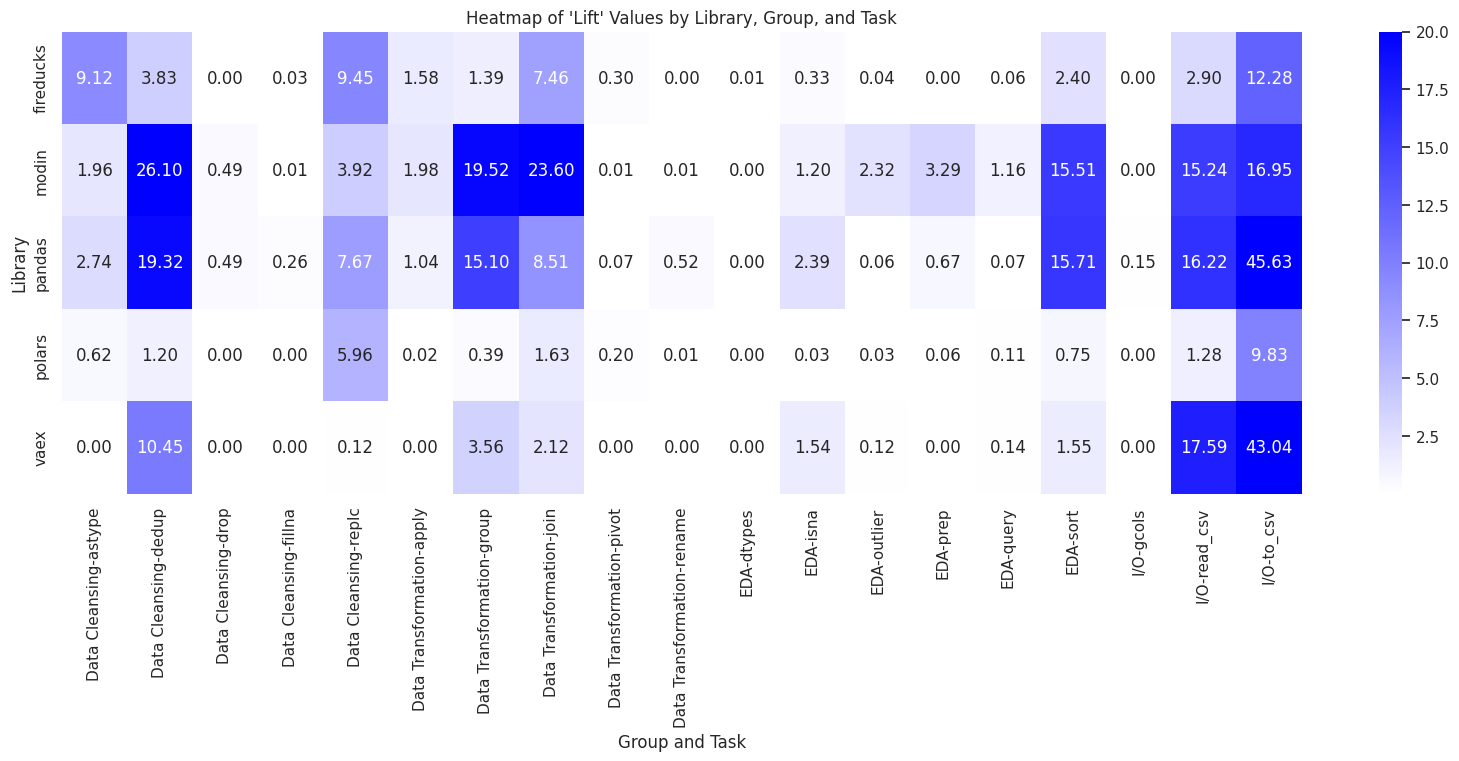

In [103]:
from matplotlib.colors import LinearSegmentedColormap
# データフレームのピボット
pivot_df = df.pivot_table(index="lib", columns=["Group", "task"], values="ttl_ms", aggfunc='mean')

# 白から緑へのカラーマップを作成
cmap = LinearSegmentedColormap.from_list('custom_green', ["white", "blue"], N=256)

# ヒートマップの作成と表示、サイズとカラーパレットを指定
plt.figure(figsize=(20, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap=cmap, vmax=20)
plt.title("Heatmap of 'Lift' Values by Library, Group, and Task")
plt.xlabel("Group and Task")
plt.ylabel("Library")
plt.show()

In [105]:
df[['lib','ttl_ms']].groupby(['lib']).sum()

,ttl_ms
lib,
fireducks,51.192853
modin,133.262734
pandas,136.620653
polars,22.126119
vaex,80.232995


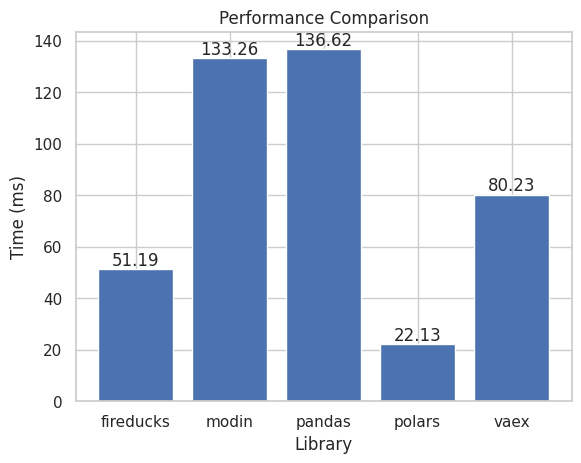

In [107]:
import matplotlib.pyplot as plt

# データの準備
data = {
    "fireducks": 51.192853,
    "modin": 133.262734,
    "pandas": 136.620653,
    "polars": 22.126119,
    "vaex": 80.232995
}

# データからバーチャートを作成
bars = plt.bar(data.keys(), data.values())

# 各バーの上に値を表示
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# タイトルとラベルの追加
plt.title("Performance Comparison")
plt.xlabel("Library")
plt.ylabel("Time (ms)")

# バーチャートの表示
plt.show()


In [114]:
df2 = df[['lib','Group','ttl_ms']].groupby(['Group','lib']).sum().reset_index()

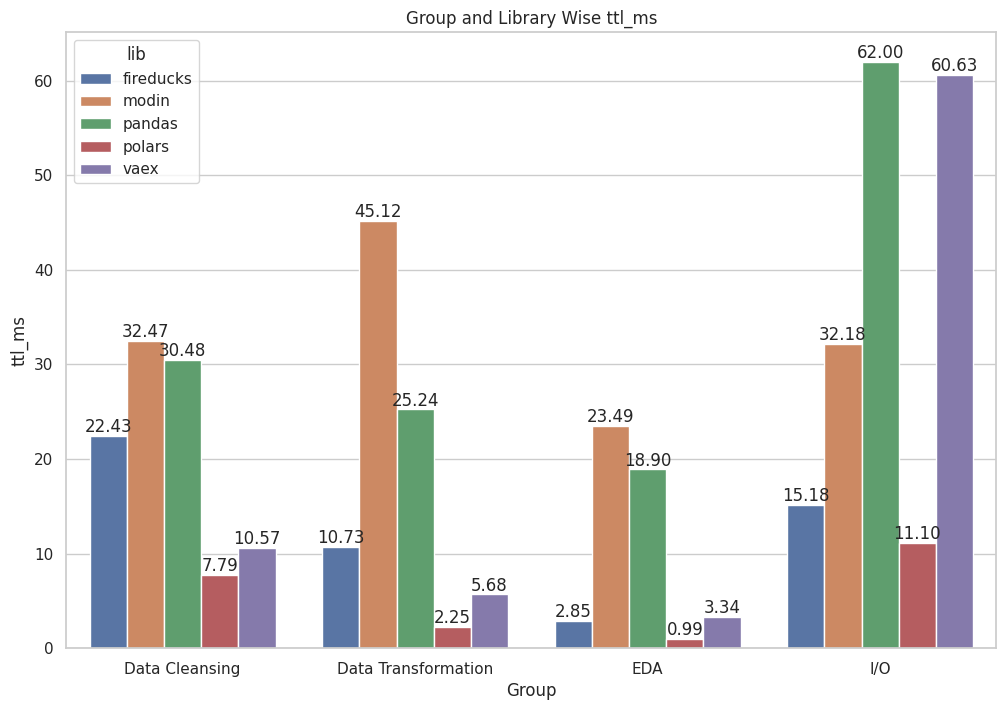

In [118]:
# プロットの作成
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Group", y="ttl_ms", hue="lib", data=df2)

# 各バーに ttl_ms の値を追加
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')
    
plt.title("Group and Library Wise ttl_ms")
plt.xlabel("Group")
plt.ylabel("ttl_ms")
plt.show()